In [1]:

import os
from os.path import dirname as up
from typing import Any, Dict, Type, cast
import pytorch_lightning as pl
from omegaconf import OmegaConf

from MarshModel import MarshModel
import smp_metrics

import pandas as pd
from dataloader import GenMARSH, RandomRotation, Resize
import torch
from torch.utils.data import DataLoader
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import imgaug as ia
import imgaug.augmenters as iaa
import torchvision.transforms as transforms
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import itertools

In [3]:

torch.manual_seed(0)
    
conf = OmegaConf.load("./config_smp.yaml")
conf_dict = OmegaConf.to_object(conf.experiment)
conf_dict = cast(Dict[Any, Dict[Any, Any]], conf_dict)

# prepare data for training
dl_kwargs = conf_dict["dataloader"]
tmi_file = dl_kwargs["labelpath"]
data_root = dl_kwargs["data_root_dir"]

transform_train = transforms.Compose([transforms.ToTensor(),
                                Resize(256)])

# load data
dataset = GenMARSH(tmi_file, data_root, transform=transform_train, normalization=dl_kwargs['normalization'], ndvi=dl_kwargs['ndvi'], ndwi=dl_kwargs['ndwi'], datasource=dl_kwargs['datasource'])

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

trainloader = DataLoader(train_dataset, 
                    batch_size = dl_kwargs["batch_size"], 
                    shuffle = True,
                    num_workers = dl_kwargs["num_workers"],
                    pin_memory = False)

testloader = DataLoader(test_dataset, 
                    batch_size = dl_kwargs["batch_size"], 
                    shuffle = False,
                    num_workers = dl_kwargs["num_workers"],
                    pin_memory = False)
    


In [4]:
# get some random training images
dataiter = iter(trainloader)
batch = dataiter.next()


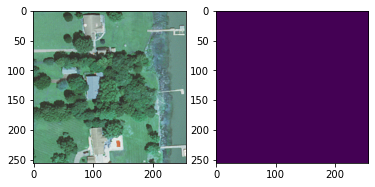

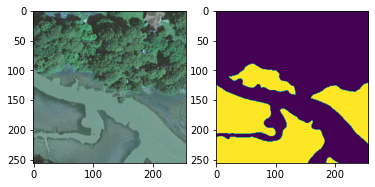

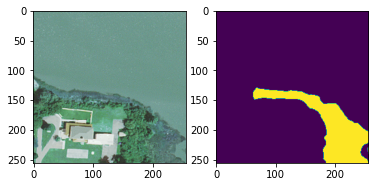

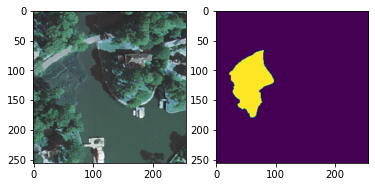

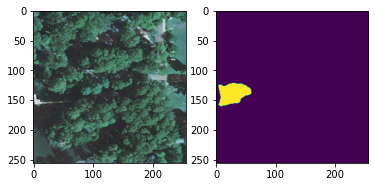

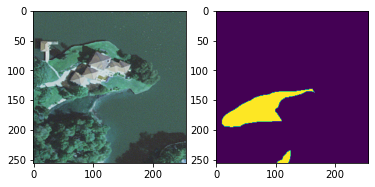

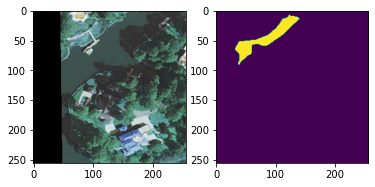

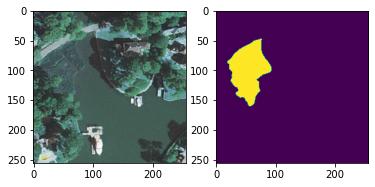

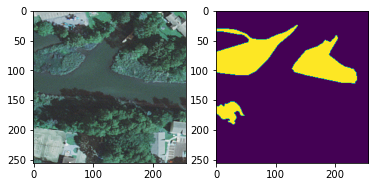

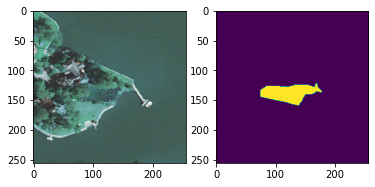

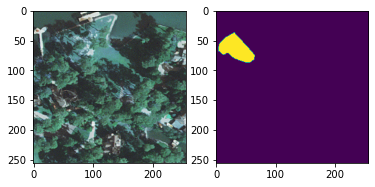

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def show_image(image, label):

    rgb_img = np.stack((image[2,:,:], image[1,:,:], image[0,:,:]), axis=2).astype(np.uint8)
    gray_img = image[0,:,:][:, :,np.newaxis]
    
    label = np.transpose(label, (1,2,0))
    
    f = plt.figure()
    f.add_subplot(1,2,1)
    plt.imshow(rgb_img)
    
    f.add_subplot(1,2,2)
    plt.imshow(gray_img)

    plt.show(block=True)
    

def display_NAIP(image, label):
    
    # reshape data
    ndata = np.moveaxis(image.numpy(), 0, -1)  # ndata is of shape (40, 40, 13)
    # select RGB (or any other combination)
    rgb = ndata[...,[2,1,0]]
    
    nlabel = np.moveaxis(label.numpy(), 0, -1)
    
    f = plt.figure()
    f.add_subplot(1,2,1)
    plt.imshow(rgb)
    
    f.add_subplot(1,2,2)
    plt.imshow(nlabel)
    plt.show(block=True)


for i in range(20):
    
    sample = dataset[i]
    display_NAIP(**sample)

    if i == 10:
        break

In [ ]:
# # load model parameters
# model_kwargs = conf_dict["module"]
# model = MarshModel(**model_kwargs)


# experiment_name = f"{model_kwargs['arch']}_{model_kwargs['encoder_name']}_0.001"
# experiment_dir = os.path.join(dl_kwargs["out_dir"], experiment_name)
# logger = TensorBoardLogger(experiment_dir, name="models")

# early_stop_callback = EarlyStopping(monitor="valid_dataset_iou", min_delta=0.00, patience=5, verbose=False, mode="max")
# checkpoint_callback = ModelCheckpoint(
#         monitor='valid_dataset_iou', dirpath=experiment_dir, save_top_k=1, save_last=True, mode='max')

# trainer = pl.Trainer(
#         callbacks=[early_stop_callback, checkpoint_callback],
#         logger=logger,
#         default_root_dir=experiment_dir,
#         min_epochs=1,
#         max_epochs=100,
#         accelerator="gpu",
#         devices=[3])

# trainer.fit(
#     model, 
#     train_dataloaders=trainloader, 
#     val_dataloaders=testloader,
# )

In [ ]:
model_options = ['unet', 'fpn', 'pspnet', 'deeplabv3', 'deeplabv3plus', 'pan', 'manet', 'linknet']
encoder_options = ['resnet34']
lr_options = [1e-4]
weight_init_options = ["imagenet"]
in_channel = 4
out_channel = 1

for (model, encoder, lr) in itertools.product(
        model_options,
        encoder_options,
        lr_options):
    
    experiment_name = f"MarshModel_{model}_{encoder}_{lr}"
    
    print(experiment_name)
    
    experiment_dir = os.path.join(dl_kwargs["out_dir"], experiment_name)
    logger = TensorBoardLogger(experiment_dir, name="models")

    early_stop_callback = EarlyStopping(monitor="valid_dataset_iou", min_delta=0.00, patience=5, verbose=False, mode="max")
    checkpoint_callback = ModelCheckpoint(
            monitor='valid_dataset_iou', dirpath=experiment_dir, save_top_k=1, save_last=True, mode='max')
    
    # load model parameters
    model = MarshModel(model, encoder_name=encoder, in_channels=in_channel, out_classes=out_channel)

    trainer = pl.Trainer(
        callbacks=[early_stop_callback, checkpoint_callback],
        logger=logger,
        default_root_dir=experiment_dir,
        min_epochs=1,
        max_epochs=100,
        accelerator="gpu",
        devices=[3])

    trainer.fit(
        model, 
        train_dataloaders=trainloader, 
        val_dataloaders=testloader,
    )

MarshModel_unet_resnet34_0.0001


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./outputs_binary_tmi_naip/MarshModel_unet_resnet34_0.0001/models
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.758    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/vims/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/opt/conda/envs/vims/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

MarshModel_fpn_resnet34_0.0001


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./outputs_binary_tmi_naip/MarshModel_fpn_resnet34_0.0001/models
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.634    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

MarshModel_pspnet_resnet34_0.0001


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./outputs_binary_tmi_naip/MarshModel_pspnet_resnet34_0.0001/models
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type     | Params
-------------------------------------
0 | model   | PSPNet   | 21.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.764    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

MarshModel_deeplabv3_resnet34_0.0001


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./outputs_binary_tmi_naip/MarshModel_deeplabv3_resnet34_0.0001/models
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type      | Params
--------------------------------------
0 | model   | DeepLabV3 | 26.0 M
1 | loss_fn | DiceLoss  | 0     
--------------------------------------
26.0 M    Trainable params
0         Non-trainable params
26.0 M    Total params
104.041   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

MarshModel_deeplabv3plus_resnet34_0.0001


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./outputs_binary_tmi_naip/MarshModel_deeplabv3plus_resnet34_0.0001/models
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type          | Params
------------------------------------------
0 | model   | DeepLabV3Plus | 22.4 M
1 | loss_fn | DiceLoss      | 0     
------------------------------------------
22.4 M    Trainable params
0         Non-trainable params
22.4 M    Total params
89.762    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

MarshModel_pan_resnet34_0.0001


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./outputs_binary_tmi_naip/MarshModel_pan_resnet34_0.0001/models
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type     | Params
-------------------------------------
0 | model   | PAN      | 21.5 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
21.5 M    Trainable params
0         Non-trainable params
21.5 M    Total params
85.916    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

MarshModel_manet_resnet34_0.0001


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./outputs_binary_tmi_naip/MarshModel_manet_resnet34_0.0001/models
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type     | Params
-------------------------------------
0 | model   | MAnet    | 31.8 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
31.8 M    Trainable params
0         Non-trainable params
31.8 M    Total params
127.147   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

MarshModel_linknet_resnet34_0.0001


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./outputs_binary_tmi_naip/MarshModel_linknet_resnet34_0.0001/models
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Linknet  | 21.8 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
21.8 M    Trainable params
0         Non-trainable params
21.8 M    Total params
87.100    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]